# Full Stats, Haccytrees, Abundances
This notebook will be like a combination of Haccytrees.ipynb and LJ-Full_Fossil_Groups.ipynb. After this one is finished, those notebooks may be cleaned up or deleted

## Set Up

In [1]:
import haccytrees.mergertrees
import h5py
import numpy as np
import numba
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from itertools import groupby
from matplotlib.ticker import ScalarFormatter
%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_func_haccytrees

plt.rcParams.update({
    "text.usetex": True,
    'font.size': 13,
    "figure.figsize": (5.25, 3.5),#(6.25, 4.25), #(6.25, 3.75)
    "patch.linewidth": 1
})

pyfftw not available, using numpy fft


In [2]:
%%time
with h5py.File("/data/a/cpac/mbuehlmann/LastJourney/forest/z0_catalog.hdf5", "r") as f:
    data = {
        k: d[:] for k, d in f.items()
    }
s = np.argsort(data['tree_node_index'])
data = {k: data[k][s] for k in data.keys()} # all halos at z=0 above a certain mass threshold

CPU times: user 36.7 s, sys: 53 s, total: 1min 29s
Wall time: 2min 9s


In [3]:
%%time
fg_forest_lm5, fg_progenitor_array_lm5 = haccytrees.mergertrees.read_forest(
    "/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest.hdf5",
    'LastJourney',
    mass_threshold=5e11
)

CPU times: user 30.5 s, sys: 37.6 s, total: 1min 8s
Wall time: 1min 8s


#### What is `data`?
`data` is a dictionary containing only the halo information we are interested in (i.e. just at $z=0$). Use `data.keys()` to see what's inside. You can treat `data` largely like you treated `forest`: i.e. to get a `key` for a specific subset of halos, use `data['key_name'][halo_idx]`.
On the fossil groups side, the equivalent of `data` is `fg_catalog`, which consists only of $z=0$ information for halos we have previously identified as fossil groups. We create `fg_catalog` from `fg_forest.hdf5` below.

In [4]:
data.keys()

dict_keys(['delta+1_rsoft0.0', 'delta+1_rsoft1.0', 'delta+1_rsoft10.0', 'delta+1_rsoft2.0', 'delta+1_rsoft4.0', 'filenum', 'index', 'sig_rsoft_0.0', 'sig_rsoft_1.0', 'sig_rsoft_10.0', 'sig_rsoft_2.0', 'sig_rsoft_4.0', 'sod_halo_cdelta', 'sod_halo_cdelta_accum', 'sod_halo_cdelta_peak', 'tree_node_index', 'tree_node_mass', 'x', 'xoff_com', 'xoff_fof', 'xoff_sod', 'y', 'z'])

In [39]:
%%time
mask_z0 = fg_forest_lm5['snapnum'] == 100
fg_catalog_lm5 = {k: fg_forest_lm5[k][mask_z0] for k in fg_forest_lm5.keys()} # forest data at z=0 # Why is this different from `assign_fgs()`?
print(fg_catalog_lm5, "\n")
s = np.argsort(fg_catalog_lm5['tree_node_index']) # How is this being sorted exactly?
fg_catalog_lm5 = {k: fg_catalog_lm5[k][s] for k in fg_catalog_lm5.keys()}
print(fg_catalog_lm5)

{'branch_size': array([492, 626, 722, ..., 688, 495, 846], dtype=int32), 'desc_node_index': array([-1, -1, -1, ..., -1, -1, -1]), 'fof_halo_center_x': array([  33.078995,   28.99692 ,   10.355293, ..., 3374.1975  ,
       3378.541   , 3351.8428  ], dtype=float32), 'fof_halo_center_y': array([  23.300694,   27.697847,   34.30774 , ..., 3376.977   ,
       3382.3665  , 3348.0195  ], dtype=float32), 'fof_halo_center_z': array([ 105.93779,   86.71628,  100.24692, ..., 3367.3103 , 3230.039  ,
       3360.602  ], dtype=float32), 'fof_halo_count': array([4456, 4510, 4583, ..., 6411, 4017, 7019], dtype=int32), 'fof_halo_mass': array([1.2108718e+13, 1.2255457e+13, 1.2453827e+13, ..., 1.7421227e+13,
       1.0915781e+13, 1.9073405e+13], dtype=float32), 'fof_halo_tag': array([  15954258774,   10983351053,    6128350018, ..., 1233857027989,
       1239752876002, 1226804393354]), 'snapnum': array([100, 100, 100, ..., 100, 100, 100], dtype=int16), 'sod_halo_cdelta': array([8.462209 , 6.3451595, 4.42

In [9]:
%%time
fg_forest_lm3, fg_progenitor_array_lm3 = haccytrees.mergertrees.read_forest(
    "/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest_lm3e11.hdf5",
    'LastJourney',
    mass_threshold=3e11
)

fg_forest_lm15, fg_progenitor_array_lm15 = haccytrees.mergertrees.read_forest(
    "/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest_lm1.5e11.hdf5",
    'LastJourney',
    mass_threshold=1.5*10**11
)

mask_z0 = fg_forest_lm3['snapnum'] == 100
fg_catalog_lm3 = {k: fg_forest_lm3[k][mask_z0] for k in fg_forest_lm3.keys()} # forest data at z=0
s = np.argsort(fg_catalog_lm3['tree_node_index']) # Why do we need this sorting?
fg_catalog_lm3 = {k: fg_catalog_lm3[k][s] for k in fg_catalog_lm3.keys()}

mask_z0 = fg_forest_lm15['snapnum'] == 100
fg_catalog_lm15 = {k: fg_forest_lm15[k][mask_z0] for k in fg_forest_lm15.keys()} # forest data at z=0
s = np.argsort(fg_catalog_lm15['tree_node_index']) # Why do we need this sorting?
fg_catalog_lm15 = {k: fg_catalog_lm15[k][s] for k in fg_catalog_lm15.keys()}

CPU times: user 17.6 s, sys: 20.3 s, total: 37.8 s
Wall time: 37.8 s


In [7]:
# To create an index of fossil groups
# (Is this what allows you to go between data and fgs?)
@numba.jit(nopython=True)
def assign_fgs(full_tn_index, fg_tn_index): # Why is this so complicated just to produce 'index'? I guess it's actually not the same as 'index'
    n_full = len(full_tn_index)
    n_fg = len(fg_tn_index)
    c_full_idx = 0
    c_fg_idx = 0
    fg_index = np.empty(n_fg, dtype=np.int64)
    fg_index[:] = -1
    while c_full_idx < n_full and c_fg_idx < n_fg:
        if full_tn_index[c_full_idx] == fg_tn_index[c_fg_idx]:
            fg_index[c_fg_idx] = c_full_idx
            c_fg_idx += 1
        else:
            c_full_idx += 1
    return fg_index
#fg_idx = assign_fgs(data['tree_node_index'], fg_catalog['tree_node_index'])
#all_halos_idx = data['index'] # Wrong lol

In [7]:
print(len(fg_catalog['tree_node_mass'][(fg_catalog['tree_node_mass'] > 10**13) & (fg_catalog['tree_node_mass'] < 10**14)]))

953215


In [6]:
print(fg_catalog_lm5.keys())

dict_keys(['branch_size', 'desc_node_index', 'fof_halo_center_x', 'fof_halo_center_y', 'fof_halo_center_z', 'fof_halo_count', 'fof_halo_mass', 'fof_halo_tag', 'snapnum', 'sod_halo_cdelta', 'sod_halo_cdelta_accum', 'sod_halo_cdelta_error', 'sod_halo_cdelta_peak', 'sod_halo_count', 'sod_halo_mass', 'sod_halo_radius', 'tree_node_index', 'tree_node_mass', 'xoff_com', 'xoff_fof', 'xoff_sod', 'scale_factor', 'descendant_idx', 'progenitor_count', 'progenitor_offset', 'halo_index'])


### Mass Matching/Narrow Bins

In [44]:
halo_masks = help_func_haccytrees.make_masks(data, pre_masked_z0 = True)
fg_masks_lm5 = help_func_haccytrees.make_masks(fg_forest_lm5)
#print(fg_masks_lm5[0][0:100])
#fg_masks_lm51 = help_func_haccytrees.make_masks(fg_catalog_lm5, pre_masked_z0 = True) # previously this was forest? Will that be a problem? # I think catalog is just a forest at z = 0
#print(fg_masks_lm51[0][0:100])
#fg_masks_lm3 = help_func_haccytrees.make_masks(fg_catalog_lm3, pre_masked_z0 = True)
#fg_masks_lm15 = help_func_haccytrees.make_masks(fg_catalog_lm15, pre_masked_z0 = True)

### Create random sample (to give to Michael!)
Here's how we created the random sample. It is built to include three narrow mass bins (same as the default bins in `make_masks()` and in each mass bin, there should be as many halos (random) as there are total number of fossils in that halo (as calculated from the `fg_forest`)

In [42]:
tn_idx = []
mass = []
idx = []
file = []
for this_bin in [mbin_thin_13_0, mbin_thin_13_3, mbin_thin_13_6]:
    bin_mask = (data['tree_node_mass'] > this_bin[0]) & (data['tree_node_mass'] < this_bin[1])
    bin_mask_idx, = np.nonzero(bin_mask)
    n_fgs = len(fg_idx[(fg_catalog['tree_node_mass'] > this_bin[0]) & (fg_catalog['tree_node_mass'] < this_bin[1])])
    random_sample_mask = np.random.choice(bin_mask_idx, n_fgs, replace = False)
    
    tn_idx.append(data['tree_node_index'][random_sample_mask])
    mass.append(data['tree_node_mass'][random_sample_mask])
    idx.append(data['index'][random_sample_mask])
    file.append(data['filenum'][random_sample_mask])
    
create_file = False
if create_file:
    with h5py.File('random_sample.h5', 'w') as f:
        f.create_dataset('tree_node_index', data=np.concatenate(tn_idx))
        f.create_dataset('tree_node_mass', data=np.concatenate(mass))
        f.create_dataset('index', data=np.concatenate(idx))
        f.create_dataset('file', data=np.concatenate(file))

NameError: name 'mbin_thin_13_0' is not defined

In [51]:
with h5py.File('random_sample.h5', 'r') as hf: # 'r' = read
    print(hf.keys())
    print(len(hf['tree_node_index']))

<KeysViewHDF5 ['file', 'index', 'tree_node_index', 'tree_node_mass']>
307993


## Abundances

In [5]:
def calc_Poisson_errors(A, B): #for function f=A/B
    return np.sqrt(A/B**2 + A**2/B**3)

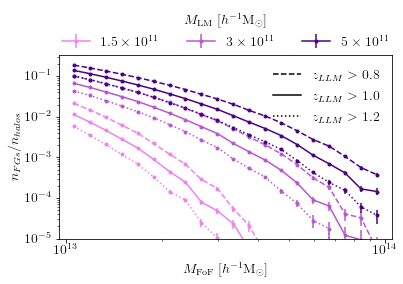

In [7]:
plt.rcParams.update({
    'font.size': 14,
    "figure.figsize": (5.83, 3.5), #(5.2, 3.13), #(5.4, 3.25), #(5.83, 3.5),#(6.25, 4.25), #(6.25, 3.75)
})

# Load in the fg fraction data
mystery_bus = np.load('/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest_fractions.npz')

# Prep for plotting
fig, ax = plt.subplots()
dexes = np.logspace(13, 14, 21)
bin_centers = (dexes[:-1] + dexes[1:]) / 2
linestyles = ["--", "-", ":"]
ls_labels = [r"$z_{LLM}>0.8$", r"$z_{LLM}>1.0$", r"$z_{LLM}>1.2$"] # Could also get from 'lm_masses', but that's more work
colors = ["violet", "mediumorchid", "indigo"]
c_labels = [r"$1.5\times 10^{11}$", r"$3\times 10^{11}$", r"$5\times 10^{11}$"] # h^{-1}\mathrm{M}_{\odot}

for i, this_z_cutoff in enumerate(mystery_bus['fg_fraction']): # loop over z-cutoffs (linestyles)
    for j, this_lm_thresh in enumerate(this_z_cutoff): # loop over llm mass thresholds (colors)
        errors = calc_Poisson_errors(mystery_bus['fg_counts'][i][j], mystery_bus['al_counts'])
        #print(errors)
        label = c_labels[j] if i==1 else None
        ax.errorbar(bin_centers, this_lm_thresh, yerr =  errors, marker = '.', label = label, color = colors[j], linestyle = linestyles[i])

legend1 = ax.legend(loc = "upper center", frameon = False, ncol = 3, bbox_to_anchor=(0.5, 1.3), title = r"$M_\mathrm{LM} \; [h^{-1} \mathrm{M}_\odot]$") # Using lines instead of patches here, because I want to show error bars

# Legend for z-cutoffs (linestyles)
fake_lines2 = [ax.plot([],[], linestyle = this_linestyle, c = 'k')[0] for this_linestyle in linestyles]
ax.legend(handles = fake_lines2, labels = ls_labels, loc = "upper right", frameon = False)
#ax.legend(handles = fake_lines2, labels = ls_labels, loc = "upper center", frameon = False, ncol = 3, bbox_to_anchor=(0.45, 1.25))
ax.add_artist(legend1)

# Cosmetics
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(bottom = 1e-5)
ax.set_xlabel(r"$M_\mathrm{FoF}$ $[h^{-1} \mathrm{M}_{\odot}]$")
ax.set_ylabel("$n_{FGs} / n_{halos}$") # How to indicate this is the total?
plt.tight_layout()
fig.savefig("full_lj_plots/fg_fractions_by_bin_log-log.pdf", bbox_inches='tight', pad_inches=0)

## Old Way

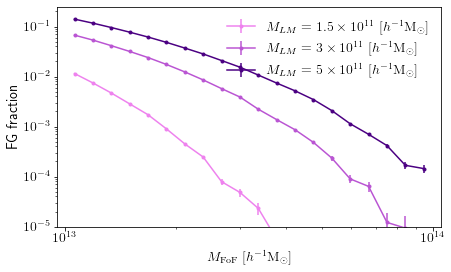

In [70]:
bin_centers = (dexes[:-1] + dexes[1:]) / 2
fig, ax = plt.subplots(figsize = (6.5,4))
#cmap = plt.color_palette("rocket")
#colors = ["#B98CD9", "#5D3A9B", "#3C1C4A"]
#colors = ["violet", "mediumorchid", "purple"]
colors = ["violet", "mediumorchid", "indigo"]
labels = [r"$M_{LM} = 1.5\times 10^{11}$ $[h^{-1}\mathrm{M}_{\odot}]$", r"$M_{LM} = 3\times 10^{11}$ $[h^{-1}\mathrm{M}_{\odot}]$", r"$M_{LM} = 5\times 10^{11}$ $[h^{-1}\mathrm{M}_{\odot}]$"] # h^{-1}\mathrm{M}_{\odot}
for i, (fractions, errors) in enumerate(zip(fractions_by_bin, errors_by_bin)):
    ax.errorbar(bin_centers, fractions, yerr =  errors, marker = '.', label = labels[i], color = colors[i])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(bottom = 1e-5)
ax.set_xlabel(r"$M_\mathrm{FoF}$ $[h^{-1} \mathrm{M}_{\odot}]$")
ax.set_ylabel("FG fraction")
ax.legend(frameon = False) # title = r"mass threshold $(h^{-1} \mathrm{M}_{\odot})$"
#fig.savefig("full_lj_plots/fg_fractions_by_bin.png")
plt.tight_layout()
#fig.savefig("full_lj_plots/fg_fractions_by_bin_log-log.png", bbox_inches='tight', pad_inches=0)

### Abundances by thirds

In [13]:
mass_mask = (data['tree_node_mass'] > 1e13) & (data['tree_node_mass'] < 1e14)
sorted_idx = np.argsort(data['tree_node_mass'][mass_mask])
mass_onethird = np.quantile(data['tree_node_mass'][mass_mask][sorted_idx], 1/3) # Huh, comes up with a slightly different value? Ohhh cause the other version rounds (why?)
mass_twothirds = np.quantile(data['tree_node_mass'][mass_mask][sorted_idx], 2/3)
thirds = [1e13, mass_onethird, mass_twothirds, 1e14]
print("Bin edges: ", np.log10(thirds))

bins_by_thirds = [[thirds[i], thirds[i+1]] for i in range(len(thirds) - 1)]
thirds_masks = make_masks(data, bins_by_thirds)
fg_thirds_masks = make_masks(fg_catalog_lm5, bins_by_thirds)

print("Halo counts by bin: ", [len(mask[mask]) for mask in thirds_masks])
print("FG counts by bin:   ", [len(mask[mask]) for mask in fg_thirds_masks])
print("Fractions by bin:   ", np.array([len(mask[mask]) for mask in fg_thirds_masks]) / np.array([len(mask[mask]) for mask in thirds_masks]))

halo_sum = 0
fg_sum = 0
for halo_mask, fg_mask in zip(thirds_masks, fg_thirds_masks):
    halo_sum += len(halo_mask[halo_mask])
    fg_sum += len(fg_mask[fg_mask])
    
print("Total halos:    ", halo_sum)
print("Total fgs:      ", fg_sum)
print("Total fraction: ", fg_sum / halo_sum)
print("Error:          ", calc_Poisson_errors(halo_sum, fg_sum))

Bin edges:  [13.         13.15356712 13.39051353 14.        ]
Halo counts by bin:  [5273458, 5276279, 5275927]
FG counts by bin:    [624726, 282177, 46312]
Fractions by bin:    [0.1184661  0.0534803  0.00877798]
Total halos:     15825664
Total fgs:       953215
Total fraction:  0.06023222785470486
Error:           0.01750959656383597


### Abundances in narrow mass bins

In [58]:
halo_counts = [len(mask[mask]) for mask in halo_masks]
fg_counts = [len(mask[mask]) for mask in fg_masks_lm5]
fraction = np.array(fg_counts) / np.array(halo_counts)
qh_counts = []
for this_mask in fg_masks_lm5:
    target_idx = np.nonzero(this_mask)[0]
    my_forest = fg_forest_lm5 # Make sure this is the same as what you fed to `make_masks()`
    my_progenitor_array = fg_progenitor_array_lm5
    mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(target_idx, my_forest)
    mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(my_forest, my_progenitor_array, mainbranch_index)
    major_mergers = help_func_haccytrees.get_major_mergers(mainbranch_mergers)
    lmm_redshifts = help_func_haccytrees.get_lmms(major_mergers)
    fgs, rugs, mrich = help_func_haccytrees.find_specials(my_forest, mainbranch_index, major_mergers, lmm_redshifts, target_idx)
    qh_counts.append(len(rugs))
    
qh_fraction = np.array(qh_counts) / np.array(fg_counts)

halo_std = [count**(1/2) for count in halo_counts]
fg_std = [count**(1/2) for count in fg_counts]
fraction_error = calc_Poisson_errors(np.array(fg_counts), np.array(halo_counts))
qh_fraction_error = calc_Poisson_errors(np.array(qh_counts), np.array(fg_counts))

print("Halo counts by bin:         ", halo_counts)
print("Halo error:                 ", halo_std)
print("FG counts by bin:           ", fg_counts)
print("FG error:                   ", fg_std)
print("FG fractions by bin:        ", fraction)
print("FG frac uncertainty by bin: ", fraction_error)
print("qh counts by bin:           ", qh_counts)
print("qh fractions by bin:        ", qh_fraction)
print("qh frac uncertainty by bin: ", qh_fraction_error)

Halo counts by bin:          [1919589, 975970, 474295]
Halo error:                  [1385.4923312671203, 987.9119393954098, 688.6907869283573]
FG counts by bin:            [269358, 36181, 2454]
FG error:                    [518.9971098185423, 190.21303845951255, 49.53786430600334]
FG fractions by bin:         [0.14032066 0.03707184 0.005174  ]
FG frac uncertainty by bin:  [0.00028872 0.00019848 0.00010472]
qh counts by bin:            [30077, 294, 0]
qh fractions by bin:         [0.1116618  0.00812581 0.        ]
qh frac uncertainty by bin:  [0.00067885 0.00047583 0.        ]


In [59]:
# In total
total_fgs = 953215
total_halos = 15825664
print(total_fgs / total_halos)
total_fraction_error = calc_Poisson_errors(total_fgs, total_halos)
print(total_fraction_error)
print(0.006 * 10**(-2))

my_forest = fg_forest_lm5 # Make sure this is the same as what you fed to `make_masks()`
my_progenitor_array = fg_progenitor_array_lm5
target_idx = help_func_haccytrees.find_halos(my_forest, [1e13, 1e14])
mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(target_idx, my_forest)
mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(my_forest, my_progenitor_array, mainbranch_index)
major_mergers = help_func_haccytrees.get_major_mergers(mainbranch_mergers)
lmm_redshifts = help_func_haccytrees.get_lmms(major_mergers)
fgs, rugs, mrich = help_func_haccytrees.find_specials(my_forest, mainbranch_index, major_mergers, lmm_redshifts, target_idx)
total_qh = len(rugs)

qh_fraction = np.array(total_qh) / np.array(total_fgs)
qh_fraction_error = calc_Poisson_errors(np.array(total_qh), np.array(total_fgs))
print(qh_fraction)
print(qh_fraction_error)

0.06023222785470486
6.352343784405087e-05
6e-05
0.06294592510608835
0.0002649378222069446
